In [119]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import sys
%matplotlib inline

In [120]:
#reading the input
image = cv2.imread('test_images/test.jpeg')
lane_image = np.copy(image)

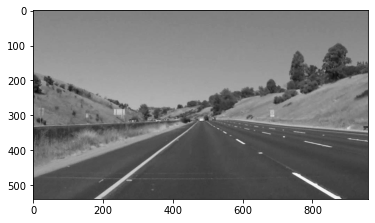

In [121]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# grayscale the image
grayscaled = grayscale(image)

###
plt.imshow(grayscaled,cmap='gray')

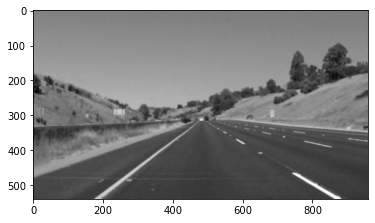

In [122]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
  
# apply gaussian blur
kernelSize = 5
gaussianBluredImg = gaussian_blur(grayscaled, kernelSize)
#o/p image
plt.imshow(gaussianBluredImg,cmap='gray')

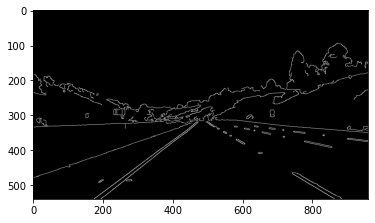

In [123]:
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

# canny edge detection
minThreshold = 50
maxThreshold = 150
edgeDetectedImage = canny(gaussianBluredImg, minThreshold, maxThreshold)
#o/p image
plt.imshow(edgeDetectedImage,cmap='gray')

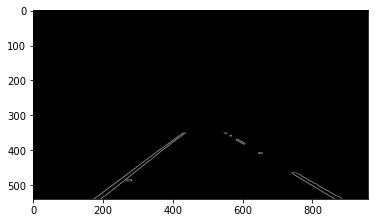

In [124]:
# test/image1 and test/image2 has different camera angle
# this varies the region of interest
# does this deffer with landscape?

def region_of_interest(img):
    #calculating the height of an image
    height=img.shape[0]
    width=img.shape[1]
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a polygon as region of interest
    
    #quad for test image1
    lowerLeftPoint = [130, 540]
    upperLeftPoint = [410, 350]
    upperRightPoint = [570, 350]
    lowerRightPoint = [915, 540]

    polygon = np.array([
        [lowerLeftPoint, upperLeftPoint, upperRightPoint, lowerRightPoint]])
    
    # #triangle for test/image2 and test/video
    # lowerLeftPoint = [200, height]
    # upperLeftPoint = [1100, height]
    # upperRightPoint = [550, 250]


    # polygon = np.array([
    #     [lowerLeftPoint, upperLeftPoint, upperRightPoint]])


    
    #fill(or addition of) the mask with the polygon
    cv2.fillPoly(mask,polygon,255)
    
    #masking the image with the mask created mask using bitwise and
    masked_image = cv2.bitwise_and(img,mask)
    
    return masked_image

#finding masked image
masked_image = region_of_interest(edgeDetectedImage)
#o/p image
plt.imshow(masked_image,cmap='gray')

In [125]:
#determining the lines using hough probablistic transform
lines = cv2.HoughLinesP(masked_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)

In [126]:
#avraging the length of lines


def make_coordinates(image, slope, intercept):
    y1=image.shape[0] #height
    y2=int(y1*2/3)
    x1=int((y1-intercept)/slope)
    x2=int((y2-intercept)/slope)
    print(y1, y2)
    return np.array([x1,y1,x2,y2])

    

def average_slope_intercept(img, lines):
    left_fit = []
    right_fit = []
    
    #unmounting the ndarray
    for line in lines:
        x1,y1,x2,y2=line.reshape(4)
        parameters = np.polyfit((x1,x2),(y1,y2),1)
        slope = parameters[0]
        intercept = parameters[1]
        
        #dividing the left and right lane line using slope
        if slope < 0: #negative slope
            print('-ve')
            left_fit.append((slope, intercept))
        elif slope >= 0:
            print('+ve')  # positive slope
            right_fit.append((slope, intercept))
        continue

        
    #calculating the avg value of slope and intercept
    left_fit_average = np.average(left_fit, axis = 0)
    left_slope, left_intercept = left_fit_average[0], left_fit_average[1]

    right_fit_average = np.average(right_fit, axis = 0)

    right_slope, right_intercept = right_fit_average[0], right_fit_average[1]

        

        
    #making the coordinates of line to be drawn after avraging slope and intercept
    left_line = make_coordinates(img, left_slope, left_intercept)
    right_line = make_coordinates(img, right_slope, right_intercept)
    
    return np.array([left_line, right_line])
      
        
averaged_lines = average_slope_intercept(lane_image, lines)

-ve
-ve
+ve
+ve
+ve
-ve
-ve
540 360
540 360


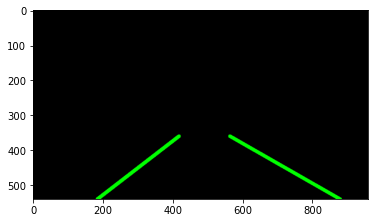

In [127]:
def display_lines(image,lines):
    mask=np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(mask,(x1,y1),(x2,y2),(0,255,0),10)
    return mask
    

# creating black images with the lines using hough probablistic transform
line_image = display_lines(lane_image, averaged_lines)

#o/p image
plt.imshow(line_image,cmap='gray')

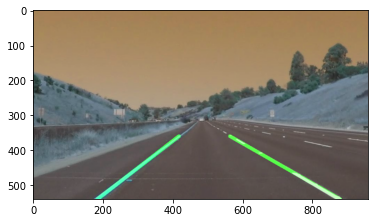

In [128]:
#adding the masked_image and line_image
lined_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)

#o/p image
plt.imshow(lined_image) 